# Paper title: Geometric properties of PalmTree instruction embeddings
## Target IJCNN, deadline: End of January


## **Overview**
*   Geometry of embeddings
*   Pairwise correlations
*   Find which are closer to which 
*   Analog relationship or outlier detection, see how embeddings relate different instructions
*   Analyze how effective basic block search is
*   Improve it by encoding pairs, or more instructions at a time
*   Do deep metric learning to improve distance matching/basic block search \

**Pairwise correlations** 
*   Correlations of the embeddings, plot them on histogram 
*   Relies on inner products between two vectors,

**Analyze** 
*   call, ret, mov, etc. most important instructions in malware analysis
*   Pick common instructions, look at embeddings see which ones are closer
*   Prediction "non of embeddings will be close/ will be perpendicular" 
*   Look at the vectors, for constants 0, 1, 2, etc. 

**Analog query** 
*   K nearest neighbors  
*   Look at vectors in  each layer, as input goes through, can see performance for analog query 
*   Find vector for king, minus vector for man + woman. find vector closest to this, see if result vector is close to king 
*   Outlier detection, look at each layer 

**Plot of embedding norms** 
*   Norm inverserly related to the frequency of tokens 
*   The most frequent tokens had smallest norm in Bert 

**For outliers, see accuracy of outliers from layer to layer**
*   Given sequence, see how it changes through the layers 
*   Look at number of layers in model 

**Basic Block Search** 
*   Do analysis, how effective the embeddings to characterize similiarities between basic blocks 
*   Average cosine distance used as similarity 

**Possible improvment**
*   Given a basic block, if encodes one instruction at time, then take average
*   Problem for instructions that are dependant on others
*   Figure out how to improve it, possible encod epair of instructions at a time

**Metric learning** "Deep Metric Learning to Rank"
*   If dataset is available, apply FastAP
*   See if it improves 







## Initialize Colab & Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab\ Notebooks/PalmTree-Trained/

/content/drive/.shortcut-targets-by-id/1LMg3kN9NvUURy3zB07RjiMQNzN0TPyMm/PalmTree-Trained


In [3]:
!pip install bert-pytorch

## Import and Load PalmTree model

In [4]:
import os
from config import *
from torch import nn
from scipy.ndimage.filters import gaussian_filter1d
from torch.autograd import Variable
import torch
import numpy as np
import eval_utils as utils
from scipy import spatial
import vocab
import pickle

palmtree = utils.UsableTransformer(model_path="./palmtree/transformer.ep19", vocab_path="./palmtree/vocab")

# tokens has to be seperated by spaces.

text = ["mov rbp rdi", 
        "mov ebx 0x1", 
        "mov rdx rbx", 
        "call memcpy", 
        "mov [ rcx + rbx ] 0x0", 
        "mov rcx rax", 
        "mov r13 qword [ rax ]",
        "mov [ rax ] 0x2e",
        "mov dword [ rsp + 0x70 ] esi" ]

# it is better to make batches as large as possible.
embeddings = palmtree.encode(text)
#for i in range(7):
#  print("usable embedding of this basicblock:", np.corrcoef(embeddings))
print("usable embedding of this basicblock:", np.linalg.norm(embeddings))

print("the shape of output tensor: ", embeddings.shape)

Loading Vocab ./palmtree/vocab
Vocab Size:  6631
usable embedding of this basicblock: 73.707214
the shape of output tensor:  (9, 128)


## Test Vocabulary

In [5]:
#Test Vocabulary
vocab_path = "./palmtree/vocab"
with open(vocab_path, "rb") as file:
  data = file.read()
  tokens = pickle.loads(data)
num_of_tokens = len(tokens)
print(tokens.to_seq(sentence="retn rbp 0x1"))
print(tokens.from_seq(seq=[5, 14, 19], join=True))
print('number of tokens', num_of_tokens)
print(tokens.from_seq(seq=list(range(0,num_of_tokens)), join=False))

[68, 14, 28]
mov rbp rdi
number of tokens 6631
['<pad>', '<unk>', '<eos>', '<sos>', '<mask>', 'mov', '[', ']', 'rax', '+', 'qword', 'address', 'eax', 'rsp', 'rbp', 'rbx', 'symbol', 'rdx', 'call', 'rdi', '-', 'dword', 'add', 'rsi', 'rcx', 'cmp', 'je', '0x8', '0x1', 'test', 'edx', 'byte', 'r12', 'lea', 'jne', 'pop', '0x0', 'jmp', 'r13', 'r14', 'xor', 'r15', 'esi', 'ecx', 'edi', '0x10', '0x28', '0x18', 'al', 'movzx', '0x20', 'sub', 'rel', 'r8', 'and', 'ebx', 'push', '0x30', 'string', '*', '0x38', '0x4', 'ebp', 'r9', 'or', '0x48', '0x40', '0x2', 'retn', 'r8d', ':', 'shl', 'fs', 'r12d', 'r10', 'r9d', '8', 'r13d', '0x5', '0x3', 'cl', 'r14d', 'ja', 'dl', '0x58', '0x50', 'r15d', 'shr', '0x60', '0x68', 'r11', 'jbe', 'word', 'jae', '0x80', '0x70', '0xc', 'movsxd', 'xmm0', 'jb', '0x90', 'xmmword', '0x78', '0xffffffffffffffff', '0x100', 'nop', '0x88', 'r10d', '4', '0xf8', '0x98', 'imul', '0x14', '0x6', 'setne', 'sete', '0xb0', 'bl', 'r11d', '0xa', '2', 'ax', 'cmovne', 'cmove', '0xa8', '0x7', '0xa0

In [ ]:
palmtree.model.embedding.token.weight.shape

torch.Size([6631, 128])

In [ ]:
#This method returns the embeddings of the tokesn after applying position and segment encoding
def get_tokens_output_embeddings(text, output_option='lst'):
    segment_label = []
    sequence = []
    for t in text:
        l = (len(t.split(' '))+2) * [1]
        s = tokens.to_seq(t)
        #print('t:',t,'l:', l,'s:', s)
        s = [3] + s + [2]
        #print(s)
        if len(l) > 20:
            segment_label.append(l[:20])
        else:
            segment_label.append(l + [0]*(20-len(l)))
        if len(s) > 20:
              sequence.append(s[:20])
        else:
            sequence.append(s + [0]*(20-len(s)))
    
    #print('segment_label',segment_label)
    #print('sequence', sequence)
    segment_label = torch.LongTensor(segment_label)
    sequence = torch.LongTensor(sequence)

    encoded = palmtree.model.forward(sequence, segment_label)
    result = encoded.detach()
    #result = torch.mean(encoded.detach(), dim=1)

    del encoded
    result = result.data.cpu().numpy()
    return result[0][0:len(s)]

In [ ]:
#Let's compare these embeddings with their original embeddings from Vocab
embedding_weights = palmtree.model.embedding.token.weight.cpu().detach().numpy()
embedding_weights.shape

(6631, 128)

In [ ]:
def compute_pairwise_cosine_sim_matrix(input_embeddings, output_embeddings):
  #create a matrix for putting the pariwise cosine_similarity values
  dim = input_embeddings.shape[0]
  cosine_matrix = np.zeros(dim*dim)
  cosine_matrix = cosine_matrix.reshape(dim,dim)
  
  for i in range(input_embeddings.shape[0]):
    for j in range(output_embeddings.shape[0]):
      result = 1 - spatial.distance.cosine(input_embeddings[i], output_embeddings[j])
      cosine_matrix[i][j] = result

  return cosine_matrix

In [ ]:
#write a method, that given an instruction Can get embeddings of the tokens from the embedding_weights
#and, then can get the output embeddings for the same tokens using the get_tokens_output_embeddings() method
def dump_cosine_sim_matrices(instruction):

  input_ins = []
  input_ins.append(instruction.replace(',',' '))
  output_embeddings = get_tokens_output_embeddings(input_ins)
  output_embeddings = np.delete(output_embeddings, 0, axis=0)  #Remove first element
  output_embeddings = np.delete(output_embeddings, -1, axis=0) #Remove last element
  #print('output_embeddings shape:',output_embeddings.shape)
  #print(result)
  #Get Embeddings for each individual token
  _indices = tokens.to_seq(sentence = input_ins[0])
  #print(_indices)
  input_embeddings = []
  for i in _indices:
    input_embeddings.append(embedding_weights[i])

  input_embeddings = np.array(input_embeddings)
  #print('input_embeddings shape:', input_embeddings.shape)

  #Finally, print out the cosine similarity between the input and output vectors for each token
  from scipy import spatial
  cosine_sim_intput_output = []
  for i in range(input_embeddings.shape[0]):
    result = 1 - spatial.distance.cosine(input_embeddings[i], output_embeddings[i])
    cosine_sim_intput_output.append(result)
  print('Cosine Similarites: input VS output')
  print(cosine_sim_intput_output)

  import pandas as pd
  pairwise_corr = compute_pairwise_cosine_sim_matrix(input_embeddings, output_embeddings) 
  df2 = pd.DataFrame(pairwise_corr)
  print('Similarity Matrix: input VS output')
  display(df2)

  pairwise_corr = compute_pairwise_cosine_sim_matrix(input_embeddings, input_embeddings) 
  df2 = pd.DataFrame(pairwise_corr)
  print('Simlarity Matrix: input ONLY')
  display(df2)

  pairwise_corr = compute_pairwise_cosine_sim_matrix(output_embeddings, output_embeddings) 
  df2 = pd.DataFrame(pairwise_corr)
  print('Similarity Matrix: output ONLY')
  display(df2)

In [ ]:
dump_cosine_sim_matrices('mov rbp rdi')

Cosine Similarites: input VS output
[0.28350630402565, 0.3152611553668976, 0.3058150112628937]
Similarity Matrix: input VS output


,0,1,2
0,0.283506,-0.143690,-0.046867
1,-0.122661,0.315261,-0.057841
2,-0.100378,-0.139555,0.305815


Simlarity Matrix: input ONLY


,0,1,2
0,1.000000,-0.014034,0.065521
1,-0.014034,1.000000,-0.007692
2,0.065521,-0.007692,1.000000


Similarity Matrix: output ONLY


,0,1,2
0,1.000000,0.141847,-0.089094
1,0.141847,1.000000,-0.199972
2,-0.089094,-0.199972,1.000000


In [ ]:
dump_cosine_sim_matrices('call,qword [ rbp + 0x30 ]')

Cosine Similarites: input VS output
[0.32940474152565, 0.3663235902786255, 0.532938539981842, 0.34341326355934143, 0.3035889267921448, 0.32224684953689575, 0.3323689103126526]
Similarity Matrix: input VS output


,0,1,2,3,4,5,6
0,0.329405,-0.081114,-0.178837,-0.199863,-0.109759,-0.118067,-0.050792
1,-0.063082,0.366324,0.069874,-0.090386,-0.116465,0.002714,0.010643
2,-0.177609,0.169051,0.532939,0.142810,0.089550,-0.088548,-0.017019
3,-0.009886,-0.060335,-0.149388,0.343413,-0.278251,-0.109994,-0.058130
4,-0.164947,-0.061138,0.035234,0.053760,0.303589,-0.082574,0.084606
5,-0.042360,0.003467,-0.026985,0.018265,-0.129437,0.322247,-0.094584
6,0.024620,-0.053918,-0.047779,-0.013329,-0.071672,0.274713,0.332369


Simlarity Matrix: input ONLY


,0,1,2,3,4,5,6
0,1.000000,-0.052634,-0.094183,-0.032848,0.005881,0.117892,0.031426
1,-0.052634,1.000000,0.159319,-0.037875,0.141862,-0.072923,0.093512
2,-0.094183,0.159319,1.000000,0.006639,0.004391,0.107033,-0.128761
3,-0.032848,-0.037875,0.006639,1.000000,0.059906,0.029616,0.040892
4,0.005881,0.141862,0.004391,0.059906,1.000000,-0.083919,0.203769
5,0.117892,-0.072923,0.107033,0.029616,-0.083919,1.000000,0.081711
6,0.031426,0.093512,-0.128761,0.040892,0.203769,0.081711,1.000000


Similarity Matrix: output ONLY


,0,1,2,3,4,5,6
0,1.000000,0.042826,-0.175584,-0.196826,-0.212696,-0.092964,-0.041597
1,0.042826,1.000000,0.310952,-0.003382,-0.108142,-0.074004,-0.119447
2,-0.175584,0.310952,1.000000,0.077703,0.062358,-0.113501,0.134413
3,-0.196826,-0.003382,0.077703,1.000000,0.001715,-0.057966,-0.001867
4,-0.212696,-0.108142,0.062358,0.001715,1.000000,-0.111555,0.179327
5,-0.092964,-0.074004,-0.113501,-0.057966,-0.111555,1.000000,-0.007842
6,-0.041597,-0.119447,0.134413,-0.001867,0.179327,-0.007842,1.000000


In [ ]:
dump_cosine_sim_matrices('mov,edi,dword [ r13 ]')

Cosine Similarites: input VS output
[0.3701731860637665, 0.2564990222454071, 0.4140365421772003, 0.4482855200767517, 0.2672283351421356, 0.3277203142642975]
Similarity Matrix: input VS output


,0,1,2,3,4,5
0,0.370173,0.190248,0.025457,-0.049151,-0.006717,-0.125896
1,-0.054048,0.256499,-0.210180,-0.042444,-0.047864,0.008940
2,-0.059067,-0.020797,0.414037,0.034467,-0.009712,-0.034344
3,0.031913,0.009137,0.029277,0.448286,0.011233,-0.068742
4,-0.159775,-0.147319,-0.038569,-0.058705,0.267228,0.078887
5,-0.022984,0.004749,-0.079582,-0.140427,-0.025067,0.327720


Simlarity Matrix: input ONLY


,0,1,2,3,4,5
0,1.000000,-0.041185,0.078311,0.103872,-0.018529,-0.031931
1,-0.041185,1.000000,-0.045216,-0.088771,-0.177196,-0.000117
2,0.078311,-0.045216,1.000000,0.073196,0.106971,0.026543
3,0.103872,-0.088771,0.073196,1.000000,0.079090,-0.128761
4,-0.018529,-0.177196,0.106971,0.079090,1.000000,0.190577
5,-0.031931,-0.000117,0.026543,-0.128761,0.190577,1.000000


Similarity Matrix: output ONLY


,0,1,2,3,4,5
0,1.000000,0.200865,0.034098,-0.133207,-0.079655,-0.116144
1,0.200865,1.000000,-0.047626,-0.011216,-0.055125,-0.067861
2,0.034098,-0.047626,1.000000,0.168634,-0.119978,-0.136540
3,-0.133207,-0.011216,0.168634,1.000000,0.032032,-0.008848
4,-0.079655,-0.055125,-0.119978,0.032032,1.000000,-0.000673
5,-0.116144,-0.067861,-0.136540,-0.008848,-0.000673,1.000000


In [ ]:
def compute_pairwise_dot_products_matrix(input_embeddings, output_embeddings):
  #create a matrix for putting the pariwise cosine_similarity values
  dim = input_embeddings.shape[0]
  dot_products_matrix = np.zeros(dim*dim)
  dot_products_matrix = dot_products_matrix.reshape(dim,dim)
  
  for i in range(input_embeddings.shape[0]):
    for j in range(output_embeddings.shape[0]):
      result = np.dot(input_embeddings[i], output_embeddings[j])
      dot_products_matrix[i][j] = result

  return dot_products_matrix

In [ ]:
#write a method, that given an instruction Can get embeddings of the tokens from the embedding_weights
#and, then can get the output embeddings for the same tokens using the get_tokens_output_embeddings() method
def dump_dot_products_matrices(instruction):

  input_ins = []
  input_ins.append(instruction.replace(',',' '))
  output_embeddings = get_tokens_output_embeddings(input_ins)
  output_embeddings = np.delete(output_embeddings, 0, axis=0)  #Remove first element
  output_embeddings = np.delete(output_embeddings, -1, axis=0) #Remove last element
  #print('output_embeddings shape:',output_embeddings.shape)
  #print(result)
  #Get Embeddings for each individual token
  _indices = tokens.to_seq(sentence = input_ins[0])
  #print(_indices)
  input_embeddings = []
  for i in _indices:
    input_embeddings.append(embedding_weights[i])

  input_embeddings = np.array(input_embeddings)
  #print('input_embeddings shape:', input_embeddings.shape)

  #Finally, print out the cosine similarity between the input and output vectors for each token
  from scipy import spatial
  dot_products_intput_output = []
  for i in range(input_embeddings.shape[0]):
    result = np.dot(input_embeddings[i], output_embeddings[i])
    dot_products_intput_output.append(result)
  print('Dot Products: input VS output')
  print(dot_products_intput_output, end='\n\n')


  #to store averages
  across_diagonal_means = []
  off_diagonal_means = []

  import pandas as pd
  pairwise_corr = compute_pairwise_dot_products_matrix(input_embeddings, output_embeddings) 
  df2 = pd.DataFrame(pairwise_corr)
  print('Dot Products Matrix: input VS output')
  display(df2)
  #average diagonal value and the average off-diagonal value
  diagonal = pairwise_corr.diagonal()
  print('Mean across the diagonal',np.mean(diagonal))
  #Store the value
  across_diagonal_means.append(np.mean(diagonal))
  sum_diagonal = np.sum(diagonal)
  sum_total = np.sum(pairwise_corr)
  #print(pairwise_corr.size, diagonal.size)
  off_diagonal_items = pairwise_corr.size - diagonal.size
  print('Mean off the diagonal',  (sum_total- sum_diagonal)/off_diagonal_items, end='\n\n')
  #Store the value
  off_diagonal_means.append((sum_total- sum_diagonal)/off_diagonal_items)
  #tuple for input_vs_output
  input_vs_output = (np.mean(diagonal), (sum_total- sum_diagonal)/off_diagonal_items)


  pairwise_corr = compute_pairwise_dot_products_matrix(input_embeddings, input_embeddings) 
  df2 = pd.DataFrame(pairwise_corr)
  print('Dot Products Matrix: input ONLY')
  display(df2)
  #average diagonal value and the average off-diagonal value
  diagonal = pairwise_corr.diagonal()
  print('Mean across the diagonal',np.mean(diagonal))
  #Store the value
  across_diagonal_means.append(np.mean(diagonal))
  sum_diagonal = np.sum(diagonal)
  sum_total = np.sum(pairwise_corr)
  #print(pairwise_corr.size, diagonal.size)
  off_diagonal_items = pairwise_corr.size - diagonal.size
  print('Mean off the diagonal',  (sum_total- sum_diagonal)/off_diagonal_items, end='\n\n')
  #Store the value
  off_diagonal_means.append((sum_total- sum_diagonal)/off_diagonal_items)
  #tuple for input_only
  input_only = (np.mean(diagonal), (sum_total- sum_diagonal)/off_diagonal_items)

  pairwise_corr = compute_pairwise_dot_products_matrix(output_embeddings, output_embeddings) 
  df2 = pd.DataFrame(pairwise_corr)
  print('Dot Products Matrix: output ONLY')
  display(df2)
  #average diagonal value and the average off-diagonal value
  diagonal = pairwise_corr.diagonal()
  print('Mean across the diagonal',np.mean(diagonal))
  #Store the value
  across_diagonal_means.append(np.mean(diagonal))
  sum_diagonal = np.sum(diagonal)
  sum_total = np.sum(pairwise_corr)
  #print(pairwise_corr.size, diagonal.size)
  off_diagonal_items = pairwise_corr.size - diagonal.size
  print('Mean off the diagonal',  (sum_total- sum_diagonal)/off_diagonal_items, end='\n\n')
  #Store the value
  off_diagonal_means.append((sum_total- sum_diagonal)/off_diagonal_items)
  #tuple for output_only
  output_only = (np.mean(diagonal), (sum_total- sum_diagonal)/off_diagonal_items)

  #return three tuples here 
  return input_vs_output, input_only, output_only
  #Overall Mean across and off diagonal
  #print('Overall Mean across diagonal:', np.mean(np.array(across_diagonal_means)))
  #print('Overall Mean off the diagonal:', np.mean(np.array(off_diagonal_means)))

In [ ]:
#get three tuples here, one for inputVoutput, then inputOnly and outputONly
#each tuple in the format of (Mean across the diagonal, Mean off the diagonal )
input_vs_output1, input_only1, output_only1 = dump_dot_products_matrices('mov rbp rdi')

Dot Products: input VS output
[122.42638, 218.88336, 172.9897]

Dot Products Matrix: input VS output


,0,1,2
0,122.426376,-108.134819,-19.068686
1,-37.112316,218.883362,-33.347691
2,-47.398552,-98.342117,172.989700


Mean across the diagonal 171.43314615885416
Mean off the diagonal -57.2340300877889

Dot Products Matrix: input ONLY


,0,1,2
0,96.542068,-1.326777,6.658401
1,-1.326777,92.580521,-0.765422
2,6.658401,-0.765422,106.969063


Mean across the diagonal 98.6972173055013
Mean off the diagonal 1.5220671494801838

Dot Products Matrix: output ONLY


,0,1,2
0,3025.719482,611.150085,-152.147934
1,611.150085,5929.260742,-910.698730
2,-152.147934,-910.698730,3352.964844


Mean across the diagonal 4102.648356119792
Mean off the diagonal -150.5655263264974



In [ ]:
input_vs_output2, input_only2, output_only2 = dump_dot_products_matrices('call,qword [ rbp + 0x30 ]')

Dot Products: input VS output
[283.8706, 109.50483, 212.23465, 301.28748, 80.54845, 242.82547, 113.12038]

Dot Products Matrix: input VS output


,0,1,2,3,4,5,6
0,283.870605,-70.989243,-118.870544,-207.911026,-63.048847,-98.927292,4.275484
1,-55.393425,109.504829,30.576260,-77.587463,-66.485695,-7.706064,9.878537
2,-109.470230,40.992516,212.234650,105.688759,35.713318,-58.732521,-32.243843
3,-17.135483,-19.311916,-66.356667,301.287476,-88.056885,-81.914848,-4.735802
4,-101.835167,-24.605986,27.631937,63.756218,80.548447,-40.770466,33.980186
5,-31.994652,0.059896,-31.509474,8.222233,-43.186584,242.825470,-51.276867
6,-0.151797,-18.144838,-2.679008,2.244862,-14.794559,153.661819,113.120377


Mean across the diagonal 191.91312190464564
Mean off the diagonal -25.93202781677246

Dot Products Matrix: input ONLY


,0,1,2,3,4,5,6
0,153.319977,-6.227128,-10.461064,-3.913569,0.579732,18.314466,2.949710
1,-6.227128,91.293083,13.654865,-3.481976,10.791220,-8.741578,6.772966
2,-10.461064,13.654865,80.464386,0.573046,0.313568,12.045575,-8.755484
3,-3.913569,-3.481976,0.573046,92.580521,4.588992,3.575174,2.982599
4,0.579732,10.791220,0.313568,4.588992,63.382328,-8.382135,12.297464
5,18.314466,-8.741578,12.045575,3.575174,-8.382135,157.404800,7.771135
6,2.949710,6.772966,-8.755484,2.982599,12.297464,7.771135,57.462982


Mean across the diagonal 99.41543960571289
Mean off the diagonal 2.2498847586768016

Dot Products Matrix: output ONLY


,0,1,2,3,4,5,6
0,4747.522461,16.370003,-573.686035,-894.591736,-335.076691,-387.856812,-73.468628
1,16.370003,1968.971680,687.474243,87.855621,-214.681885,-48.743042,-76.289505
2,-573.686035,687.474243,2271.731934,342.580475,171.433182,-117.617409,209.685150
3,-894.591736,87.855621,342.580475,7621.448242,39.063011,-812.587158,-109.631165
4,-335.076691,-214.681885,171.433182,39.063011,1584.221924,-116.797653,132.833542
5,-387.856812,-48.743042,-117.617409,-812.587158,-116.797653,5244.900391,65.357071
6,-73.468628,-76.289505,209.685150,-109.631165,132.833542,65.357071,1893.270020


Mean across the diagonal 3618.8666643415177
Mean off the diagonal -95.63692474365234



In [ ]:
input_vs_output3, input_only3, output_only3 = dump_dot_products_matrices('mov,edi,dword [ r13 ]')

Dot Products: input VS output
[182.00314, 183.78741, 239.32843, 153.30867, 203.12924, 126.98381]

Dot Products Matrix: input VS output


,0,1,2,3,4,5
0,182.003143,139.148041,-5.015149,-19.548439,-20.620228,-81.664131
1,-39.138504,183.787415,-124.663689,-16.450594,-61.184227,2.500096
2,-38.102100,-28.721992,239.328430,9.322603,10.050095,1.489248
3,21.737095,3.421120,3.466721,153.308670,16.662888,-55.105423
4,-100.406723,-102.301224,-22.561897,-42.341370,203.129242,22.699959
5,-15.109728,-20.528866,-45.569263,-24.162344,-8.769646,126.983810


Mean across the diagonal 181.42345174153647
Mean off the diagonal -21.38225574493408

Dot Products Matrix: input ONLY


,0,1,2,3,4,5
0,96.542068,-4.507939,8.108931,9.155024,-1.954959,-2.378297
1,-4.507939,124.096825,-5.308379,-8.870563,-21.196556,-0.009853
2,8.108931,-5.308379,111.063225,6.919517,12.105467,2.120473
3,9.155024,-8.870563,6.919517,80.464386,7.618253,-8.755484
4,-1.954959,-21.196556,12.105467,7.618253,115.309303,15.513021
5,-2.378297,-0.009853,2.120473,-8.755484,15.513021,57.462982


Mean across the diagonal 97.48979822794597
Mean off the diagonal 0.5705770015716553

Dot Products Matrix: output ONLY


,0,1,2,3,4,5
0,3237.347168,953.922363,-87.719513,-143.464645,-408.244141,-384.381165
1,953.922363,5198.363281,-383.210114,9.305458,-503.764160,-301.781525
2,-87.719513,-383.210114,3112.461670,371.132111,-384.927124,-93.086151
3,-143.464645,9.305458,371.132111,1457.190063,-48.816391,17.344444
4,-408.244141,-503.764160,-384.927124,-48.816391,4953.255859,33.830276
5,-384.381165,-301.781525,-93.086151,17.344444,33.830276,2907.991455


Mean across the diagonal 3477.7682495117188
Mean off the diagonal -90.25735168457031



In [ ]:
print(input_vs_output1, input_only1, output_only1)
print(input_vs_output2, input_only2, output_only2)
print(input_vs_output3, input_only3, output_only3)

(171.43314615885416, -57.2340300877889) (98.6972173055013, 1.5220671494801838) (4102.648356119792, -150.5655263264974)
(191.91312190464564, -25.93202781677246) (99.41543960571289, 2.2498847586768016) (3618.8666643415177, -95.63692474365234)
(181.42345174153647, -21.38225574493408) (97.48979822794597, 0.5705770015716553) (3477.7682495117188, -90.25735168457031)


In [ ]:
#Create the Matrix
print('\t\t Average-Diagonal\t\tAverage-Off-Diagonal')
print('input ONLY:\t', (input_only1[0]+input_only2[0]+input_only3[0])/3,'\t\t',(input_only1[1]+input_only2[1]+input_only3[1])/3)
print('input VS output:',(input_vs_output1[0]+input_vs_output2[0]+input_vs_output3[0])/3,'\t\t',(input_vs_output1[1]+input_vs_output2[1]+input_vs_output3[1])/3)
print('output ONLY:\t',(output_only1[0]+output_only2[0]+output_only3[0])/3,'\t\t',(output_only1[1]+output_only2[1]+output_only3[1])/3)

		 Average-Diagonal		Average-Off-Diagonal
input ONLY:	 98.53415171305339 		 1.4475096365762135
input VS output: 181.58990660167876 		 -34.84943788316515
output ONLY:	 3733.0944233243426 		 -112.15326758490669


## Rank Closest Instructions based on Cosine Similarity of their Embeddings

In [ ]:
#Get all the instructions Embeddings, and then Rank them
#Read the opcode.pkl file and initialize offsets for Instruction groups
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
opcode_group_file = "./intrinsic_eval/opcode.pkl"

with open(opcode_group_file, 'rb') as f:
    instruction_set = pickle.load(f)

instruction_groups = dict()

#print('instruction_set is a',type(instruction_set))
offset = 0
for ins in instruction_set:
  ins_list = instruction_set[ins]
  instruction_groups[ins] = []
  instruction_groups[ins].append(offset) #start_index
  instruction_groups[ins].append(len(ins_list)+offset-1) #end_index
  offset += len(ins_list)
#num_of_ins += len(instruction_set[ins])
#print('number of instructions:' , num_of_ins)


#instruction_groups keeps a mapping of an instruction category(i.e. MOV) and start & end indices in that category
for key, val in instruction_groups.items():
    print(key, val)

MOV [0, 4205]
BINOP [4206, 5948]
CALL [5949, 5973]
CMP [5974, 7245]
JMP [7246, 7285]
SHIFT [7286, 7438]
CSET [7439, 7482]
CMOV [7483, 7674]
UNARY [7675, 7699]
FP [7700, 7702]


In [ ]:
for key in instruction_set:
  print(key, instruction_set[key])

MOV {'mov,r8d,0x4', 'mov,r15,qword [ rax ]', 'mov,ecx,0x11', 'mov,dword [ esp + 0x4 ],0x30', 'mov,ecx,dword [ esp + 0x38 ]', 'mov,rbx,qword [ rbp - 0x308 ]', 'mov,dword [ rbp - 0x318 ],esi', 'mov,qword [ rsp + 0x10 ],rdi', 'mov,rdx,qword [ r9 ]', 'mov,rsi,qword [ rsp + 0x8 ]', 'mov,rbx,rsp', 'mov,edx,dword [ rel  symbol ]', 'mov,byte [ rbp - 0x330 ],0x1', 'mov,r13,qword [ rbp - 0x368 ]', 'mov,dword [ ebp - 0xb8 ],ecx', 'push,0x1', 'mov,ecx,0x63', 'mov,dword [ esp + 0x24 ],edi', 'mov,dword [ rsp + 0x38 ],esi', 'mov,rax,qword [ rsi + rax * 8 ]', 'mov,qword [ rsp + 0x18 ],r8', 'mov,ebx,dword [ esp + 0x24 ]', 'mov,r9,0xae985bf2cbfc89ed', 'mov,byte [ r11 ],0x23', 'mov,rbp,qword [ rbp + 0x8 ]', 'mov,r13,rdx', 'mov,qword [ rsp + 0x7e8 ],rax', 'mov,dword [ rsp + 0x48 ],0x5', 'mov,r9,qword [ rsp + 0x28 ]', 'mov,edi,0x0', 'mov,byte [ rdx ],0x5c', 'mov,qword [ r12 + 0x38 ],r13', 'mov,eax,0x3e', 'mov,rax,qword [ rbx + 0x38 ]', 'mov,rdi,qword [ rbp - 0x350 ]', 'mov,r12,qword [ rbx + 0x28 ]', 'mov,e

### Utility Methods

In [ ]:
#method which can get the instruction from instruction_set
#using the instruction_group key and index'
#Do We Really Need this?
def fetch_instruction(_index):

  for key, val in instruction_groups.items():
    start_index = instruction_groups[key][0]
    end_index = instruction_groups[key][1]
    if(_index>=start_index and _index<=end_index):
      idx = _index-start_index
      size = len(instruction_set[key])
      #print('Group:', key,"Index:", idx,"Size:",size)
      if(idx>=size):
        print("Error!")
        return ""
      return list(instruction_set[key])[idx]


In [ ]:
#Get the Embeddings for an insruction from the outlier_check_list
#Use Index from outlier_check_list
def GetInstructionEmbedding(embd_matrix, ins_index):
  size = embd_matrix.shape[0]
  if(size <= ins_index):
    print("Wrong Index!")
    return
  else:
    return embd_matrix[ins_index]


### Load the Embeddings from pickle file and Analyze

In [ ]:
#Unpickle the embeddings, and check it out 
with open('opcode_instructions_embeddings.pkl', 'rb') as f:
    embeddings_list = pickle.load(f)

In [ ]:
#check the shape of the embeddings 
all_embeddings = np.array(embeddings_list)
print(all_embeddings.shape)
#print('Sample Embedding:')
for i in range(0, 0):
  print(all_embeddings[i])

(7703, 128)


In [ ]:
#Testing fetch_instruction(_index) method
ins = fetch_instruction(2001)
print(ins)

mov,qword [ rbp + 0x48 ],0x0


In [ ]:
print(tokens.to_seq(sentence=ins.replace(',',' ')))
print(tokens.from_seq(seq=[5, 21, 6, 13, 9, 95, 7, 42], join=True))

[5, 10, 6, 14, 9, 65, 7, 36]
mov dword [ rsp + 0x70 ] esi


In [ ]:
#Get embedding of the instruction above
ins_embedding = GetInstructionEmbedding(all_embeddings, 2001)
magnitude = np.linalg.norm(ins_embedding)
print(magnitude)

20.318285


In [ ]:
#Get Embeddings of each of the tokens of the instruction above
ins_tokens = ins.replace(',',' ').split(' ')
print(ins_tokens)
ins_tokens_seq = tokens.to_seq(sentence=ins.replace(',',' '))
#print(ins_tokens_seq)

['mov', 'qword', '[', 'rbp', '+', '0x48', ']', '0x0']


In [ ]:
#Get Embeddings for all the tokens
embedding_weights = palmtree.model.embedding.token.weight.cpu().detach().numpy()

ins_tokens_seq_embeddings = []
for i in range(len(ins_tokens_seq)):
  ins_tokens_seq_embeddings.append(embedding_weights[i])
#Convert the result to a numpy array
ins_tokens_seq_embeddings = np.array(ins_tokens_seq_embeddings)

In [ ]:
#ins_tokens_seq_embeddings.shape
len = ins_tokens_seq_embeddings.shape[0]
norms = np.zeros(len)
for i in range(0,len):
  magnitude = np.linalg.norm(ins_tokens_seq_embeddings[i])
  norms[i] = magnitude

print(norms)

[ 1.61134303 10.18611622  7.69792366  7.38528967  5.04852915  9.8255825
  8.97019386  7.58043432]


## Look at Magnitudes of Token Embeddigns

In [6]:
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import pairwise_distances
embedding_weights = palmtree.model.embedding.token.weight.cpu().detach().numpy()
len = embedding_weights.shape[0]
norms = np.zeros(len)
for i in range(0,len):
  magnitude = np.linalg.norm(embedding_weights[i])
  norms[i] = magnitude


#with np.printoptions(threshold=np.inf):
norms = norms.reshape(len,1)
print(norms)

print(embedding_weights.shape)
print(norms.shape)

[[ 1.61134303]
 [10.18611622]
 [ 7.69792366]
 ...
 [ 9.59264755]
 [ 9.73288822]
 [ 9.57337475]]
(6631, 128)
(6631, 1)


In [7]:
avg = np.mean(norms)
avg

10.288248531725985

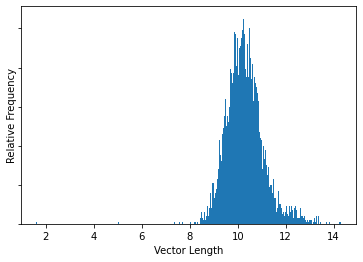

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

#plt.hist(norms,figsize=(100,200))
#fig = plt.figure(figsize=(100,200))
#plt.show()
df4 = pd.DataFrame(norms)
df4.columns = [""]
fig, ax = plt.subplots()
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    labelleft=False) # labels along the bottom edge are off
plt.xlabel("Vector Length")
plt.ylabel("Relative Frequency")
df4.hist(bins=516, grid=False, figsize=(18,24), ax=ax)
fig.savefig('token_embeddings_magnitude_distributions_final.pdf')

## The END

In [ ]:
dot_matrix=np.dot(embedding_weights,embedding_weights.T)
print(dot_matrix.shape)

In [ ]:
df3 = pd.DataFrame(dot_matrix)
print(df3)

In [ ]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15,10))

ax1.plot(df3[0][0:100]), ax1.set_title("0x0")       # 0x0
ax2.plot(df3[28]), ax2.set_title("0x1")      # 0x1
ax3.plot(df3[5]), ax3.set_title("mov")       # mov
ax4.plot(df3[18][0:100]), ax4.set_title("call ")    # call 
ax5.plot(df3[3546]), ax5.set_title("ret")    # ret
ax6.plot(df3[68]), ax6.set_title("retn")     # retn

for ax in fig.get_axes():
    ax.label_outer()  